## K2-24 Fitting & Nested Sampling

Using the K2-24 (EPIC-203771098) dataset, we demonstrate how to use the radvel API to sample the posterior distribution and calculate the evidence with Nested Sampling.
This is a copy of the K2-24 MCMC tutorial, but with Nested Sampling instead.


### Circular Orbits
Perform some preliminary imports:

In [ ]:
%matplotlib inline

import os

import matplotlib
import numpy as np
import pylab as pl
import pandas as pd
from scipy import optimize

import corner

import radvel
import radvel.likelihood
from radvel.plot import orbit_plots, mcmc_plots
import matplotlib.pyplot as plt

matplotlib.rcParams['font.size'] = 14

Define a function that we will use to initialize the ``radvel.Parameters`` and ``radvel.RVModel`` objects

In [2]:
def initialize_model():
    time_base = 2420
    params = radvel.Parameters(2,basis='per tc secosw sesinw logk') # number of planets = 2
    params['per1'] = radvel.Parameter(value=20.885258)
    params['tc1'] = radvel.Parameter(value=2072.79438)
    params['secosw1'] = radvel.Parameter(value=0.01)
    params['sesinw1'] = radvel.Parameter(value=0.01)
    params['logk1'] = radvel.Parameter(value=1.1)
    params['per2'] = radvel.Parameter(value=42.363011)
    params['tc2'] = radvel.Parameter(value=2082.62516)
    params['secosw2'] = radvel.Parameter(value=0.01)
    params['sesinw2'] = radvel.Parameter(value=0.01)
    params['logk2'] = radvel.Parameter(value=1.1)
    mod = radvel.RVModel(params, time_base=time_base)
    mod.params['dvdt'] = radvel.Parameter(value=-0.02)
    mod.params['curv'] = radvel.Parameter(value=0.01)
    return mod



Define a simple plotting function to display the data, model, and residuals

In [3]:
def plot_results(like):
    fig = pl.figure(figsize=(12,4))
    fig = pl.gcf()
    fig.set_tight_layout(True)
    pl.errorbar(
        like.x, like.model(t)+like.residuals(), 
        yerr=like.yerr, fmt='o'
        )
    pl.plot(ti, like.model(ti))
    pl.xlabel('Time')
    pl.ylabel('RV')
    pl.draw()

Load up the K2-24 data. In this example the RV data and parameter starting guesses are stored in an csv file

In [4]:
# path = os.path.join(radvel.DATADIR,'epic203771098.csv')
path = os.path.join("./example_data",'epic203771098.csv')
rv = pd.read_csv(path)

t = np.array(rv.t)
vel = np.array(rv.vel)
errvel = rv.errvel
ti = np.linspace(rv.t.iloc[0]-5,rv.t.iloc[-1]+5,100)

Fit the K2-24 RV data assuming:

1. circular orbits
2. fixed period, time of transit

Set initial guesses for the parameters. Setting vary=False and linear=True on the gamma parameters will cause them to be solved for analytically following the technique described [here](http://cadence.caltech.edu/~bfulton/share/Marginalizing_the_likelihood.pdf) (Thanks Tim Brandt!). If you use this you will need to calculate the uncertainties on gammas manually following that derivation.

In [5]:
mod = initialize_model()
like = radvel.likelihood.RVLikelihood(mod, t, vel, errvel)
like.params['gamma'] = radvel.Parameter(value=0.1, vary=False, linear=True)
like.params['jit'] = radvel.Parameter(value=1.0)

Choose which parameters to vary or fix. By default, all `radvel.Parameter` objects will vary, so you only have to worry about setting the ones you want to hold fixed.

In [6]:
like.params['secosw1'].vary = False
like.params['sesinw1'].vary = False
like.params['secosw2'].vary = False
like.params['sesinw2'].vary = False
like.params['per1'].vary = False
like.params['per2'].vary = False
like.params['tc1'].vary = False
like.params['tc2'].vary = False
print(like)

parameter                     value      vary
per1                        20.8853      False
tc1                         2072.79      False
secosw1                        0.01      False
sesinw1                        0.01      False
logk1                           1.1       True
per2                         42.363      False
tc2                         2082.63      False
secosw2                        0.01      False
sesinw2                        0.01      False
logk2                           1.1       True
dvdt                          -0.02       True
curv                           0.01       True
gamma                           0.1      False
jit                               1       True



Plot the initial model

<Figure size 432x288 with 0 Axes>

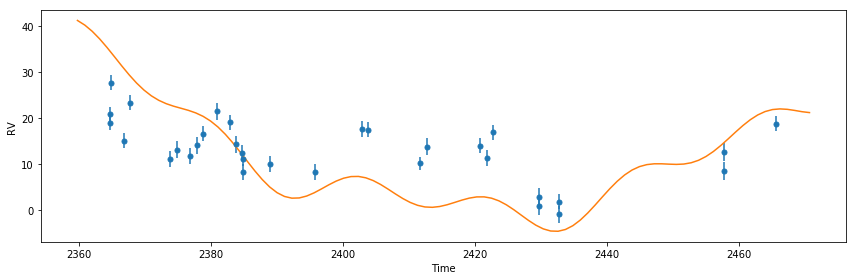

In [7]:
pl.figure()
plot_results(like)
plt.show()

Well that solution doesn't look very good. Now lets try to optimize the parameters set to vary by maximizing the likelihood.

Initialize a ``radvel.Posterior`` object and add some priors

In [8]:
post = radvel.posterior.Posterior(like)
post.priors += [radvel.prior.Gaussian( 'logk1', np.log(5), 5)]
# post.priors += [radvel.prior.HardBounds( 'logk1', -5, 5)]
# post.priors += [radvel.prior.HardBounds( 'logk2', -5, 5)]
post.priors += [radvel.prior.Gaussian( 'dvdt', 0, 1.0)]
post.priors += [radvel.prior.Gaussian( 'curv', 0, 1e-1)]
# post.priors += [radvel.prior.Gaussian( 'gamma', 0, 10)]
post.priors += [radvel.prior.ModifiedJeffreys( 'jit', 0, 10.0, -0.1)]
post.priors += [radvel.prior.Gaussian( 'logk2', np.log(5), 5)]

Maximize the likelihood and print the updated posterior object

parameter                     value      vary
per1                        20.8853      False
tc1                         2072.79      False
secosw1                        0.01      False
sesinw1                        0.01      False
logk1                       1.55037       True
per2                         42.363      False
tc2                         2082.63      False
secosw2                        0.01      False
sesinw2                        0.01      False
logk2                       1.37648       True
dvdt                     -0.0292189       True
curv                     0.00182259       True
gamma                      -3.99195      False
jit                         2.09753       True

Priors
------
Gaussian prior on jit, mu=1.0986122886681098, sigma=0.5
Gaussian prior on logk2, mu=1.6094379124341003, sigma=10
Gaussian prior on logk1, mu=1.6094379124341003, sigma=10
Gaussian prior on gamma, mu=0, sigma=10



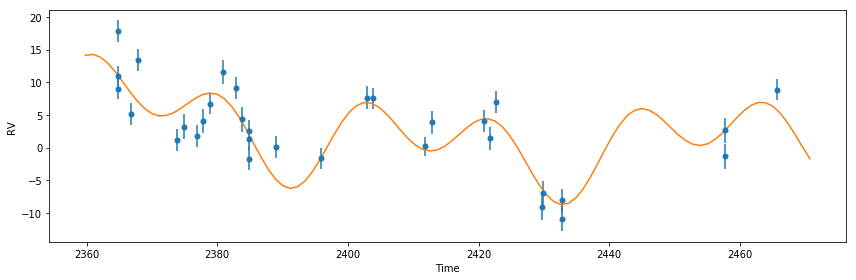

In [9]:
res  = optimize.minimize(
    post.neglogprob_array,     # objective function is negative log likelihood
    post.get_vary_params(),    # initial variable parameters
    method='Nelder-Mead',           # Powell also works
    )

plot_results(like)             # plot best fit model
plt.show()
print(post)

That looks much better!

Now lets use Nested Sampling to estimate the parameter uncertainties and bayesian evidence.
TODO: Adapt this line for NS parameters
In this example we will run 400 steps for the sake of speed but in practice you should let it run at least 10000 steps and ~50 walkers. If the chains converge before they reach the maximum number of allowed steps it will automatically stop.

In [ ]:
u = np.random.random(size=(len(post.priors), 1000))
prior_samples = post.prior_transform(u)

fig = corner.corner(prior_samples.T, labels=post.name_vary_params())
plt.show()

In [10]:
# TODO: Implement simpler nested sampling within radvel?
import dynesty
from typing import Optional, Union

def run_ns(
    post: radvel.posterior.Posterior,
    sampler_type: str = "static",
    sampler_kwargs: Optional[dict] = None,
    run_kwargs: Optional[dict] = None,
) -> Union[dynesty.NestedSampler, dynesty.DynamicNestedSampler]:
    run_kwargs = run_kwargs or {}
    sampler_kwargs = sampler_kwargs or {}
    post.check_proper_priors()
    # TODO: Support dynamic
    if sampler_type == "static":
        sampler = dynesty.NestedSampler(
            post.likelihood.logprob_array, post.prior_transform, len(post.priors), **sampler_kwargs
        )
    elif sampler_type == "dynamic":
        sampler = dynesty.DynamicNestedSampler(post.likelihood.logprob_array, post.prior_transform, len(post.priors), **sampler_kwargs)
    else:
        raise ValueError("sampler must be 'static' or 'dynamic'")
    sampler.run_nested(**run_kwargs)
    return sampler
    # dresults = dsampler.results

8000/64000 (12.5%) steps complete; Running 12210.22 steps/s; Mean acceptance rate = 57.3%; Min Auto Factor =  22; Max Auto Relative-Change =   inf; Min Tz = 1176.3; Max G-R = 1.024
Discarding burn-in now that the chains are marginally well-mixed

64000/64000 (100.0%) steps complete; Running 13032.47 steps/s; Mean acceptance rate = 55.1%; Min Auto Factor =  50; Max Auto Relative-Change = 0.169; Min Tz = 4270.9; Max G-R = 1.007

MCMC: WARNING: chains did not pass convergence tests. They are likely not well-mixed.


In [ ]:
sampler_circular = run_ns(
    post,
    sampler_type="dynamic",
    sampler_kwargs={"nlive": 300, "bound": "multi", "sample": "auto"},
    # run_kwargs={"dlogz": 1e-2},
)

Now lets make a few plots with dynesty

In [ ]:
from dynesty import plotting as dyplot

In [ ]:
dyplot.runplot(sampler_circular.results)
plt.show()

In [ ]:
dyplot.traceplot(sampler_circular.results, labels=post.name_vary_params())
plt.show()

In [ ]:
dyplot.cornerplot(sampler_circular.results, labels=post.name_vary_params(), show_titles=True)
plt.show()

### Eccentric Orbits

Allow ``secosw`` and ``sesinw`` parameters to vary

In [12]:
like.params['secosw1'].vary = True
like.params['sesinw1'].vary = True
like.params['secosw2'].vary = False
like.params['sesinw2'].vary = False

Add an ``EccentricityPrior`` to ensure that eccentricity stays below 1.0. In this example we will also add a Gaussian prior on the jitter (``jit``) parameter with a center at 2.0 m/s and a width of 0.1 m/s.

In [13]:
post = radvel.posterior.Posterior(like)
# post.priors += [radvel.prior.EccentricityPrior( 2 )]
# post.priors += [radvel.prior.EccentricityPrior( 2 )]
post.priors += [radvel.prior.HardBounds( 'secosw1', -1, 1)]
post.priors += [radvel.prior.HardBounds( 'sesinw1', -1, 1)]
post.priors += [radvel.prior.Gaussian( 'logk1', np.log(5), 5)]
# post.priors += [radvel.prior.HardBounds( 'logk1', -5, 5)]
# post.priors += [radvel.prior.HardBounds( 'secosw2', -1, 1)]
# post.priors += [radvel.prior.HardBounds( 'sesinw2', -1, 1)]
post.priors += [radvel.prior.Gaussian( 'logk2', np.log(5), 5)]
# post.priors += [radvel.prior.HardBounds( 'logk2', -5, 5)]
post.priors += [radvel.prior.Gaussian( 'dvdt', 0, 1.0)]
post.priors += [radvel.prior.Gaussian( 'curv', 0, 1e-1)]
post.priors += [radvel.prior.ModifiedJeffreys( 'jit', 0, 10.0, -0.1)]

In [ ]:
u = np.random.random(size=(len(post.priors), 1000))
prior_samples = post.prior_transform(u)

corner.corner(prior_samples.T, labels=post.name_vary_params())
plt.show()

Optimize the parameters by maximizing the likelihood and plot the result

parameter                     value      vary
per1                        20.8853      False
tc1                         2072.79      False
secosw1                    0.398041       True
sesinw1                   -0.404209       True
logk1                        1.8115       True
per2                         42.363      False
tc2                         2082.63      False
secosw2                   -0.124394       True
sesinw2                     0.37035       True
logk2                       1.48072       True
dvdt                     -0.0297857       True
curv                     0.00206207       True
gamma                      -4.52471      False
jit                          1.9542       True

Priors
------
e1 constrained to be < 0.99
e2 constrained to be < 0.99
Gaussian prior on jit, mu=0.6931471805599453, sigma=-2.3025850929940455



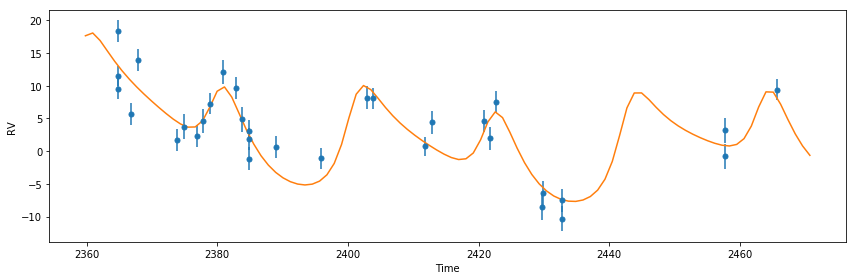

In [14]:
res  = optimize.minimize(
    post.neglogprob_array, 
    post.get_vary_params(), 
    method='Powell',)

plot_results(like)
plt.show()
print(post)

Plot the final solution

(<Figure size 540x786.857 with 5 Axes>,
  <matplotlib.axes._subplots.AxesSubplot at 0x7fc70b03ea58>])

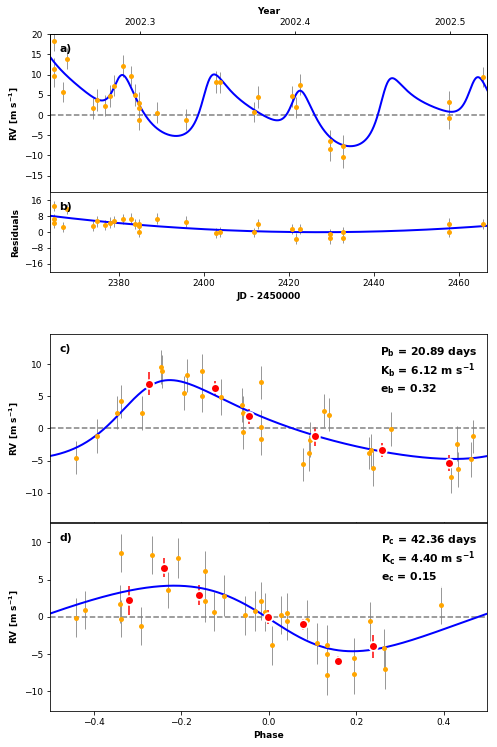

In [15]:
RVPlot = orbit_plots.MultipanelPlot(post, legend=False)
RVPlot.plot_multipanel()
plt.show()

In [ ]:
sampler_ecc = run_ns(
    post,
    sampler_type="dynamic",
    sampler_kwargs={"nlive": 50*len(post.get_vary_params()), "bound": "multi", "sample": "rwalk"},
    # run_kwargs={"dlogz": 1e-2},
)

In [ ]:
dyplot.runplot(sampler_ecc.results)
plt.show()

In [ ]:
dyplot.traceplot(sampler_ecc.results, labels=post.name_vary_params())
plt.show()

In [ ]:
dyplot.cornerplot(sampler_ecc.results, labels=post.name_vary_params(), show_titles=True)
plt.show()

In [ ]:
df = radvel.mcmc(post,nwalkers=50,nrun=1000,savename='rawchains.h5')

In [ ]:
Corner = mcmc_plots.CornerPlot(post, df)
Corner.plot()
plt.show()

In [ ]:
logz_ecc = sampler_ecc.results.logz[-1]
logz_circular = sampler_circular.results.logz[-1]

In [ ]:
logz_ecc - logz_circular